In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

In [3]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = 'flowers Dataset/train'
valid_path = 'flowers Dataset/val'
test_path = 'flowers Dataset/test'

In [4]:
# useful for getting number of output classes
folders = glob('flowers Dataset/train/*')

In [5]:
folders

['flowers Dataset/train\\daisy',
 'flowers Dataset/train\\dandelion',
 'flowers Dataset/train\\rose',
 'flowers Dataset/train\\sunflower',
 'flowers Dataset/train\\tulip']

In [7]:
# Import the Inception V3 library as shown below and add preprocessing layer to the front of InceptionV3
# Here we will be using imagenet weights

xception = Xception(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [8]:
# don't train existing weights
for layer in xception.layers:
    layer.trainable = False

In [9]:
# our layers - you can add more if you want
x = Flatten()(xception.output)

In [10]:
prediction = Dense(len(folders), activation='softmax')(x)

In [11]:
# create a model object
model = Model(inputs=xception.input, outputs=prediction)

In [12]:
# view the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [13]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [14]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   ) 
test_datagen = ImageDataGenerator(rescale = 1./255)

In [15]:
train_generator = train_datagen.flow_from_directory('flowers Dataset/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical',
                                                 ) 

Found 2593 images belonging to 5 classes.


In [16]:
valid_generator = train_datagen.flow_from_directory('flowers Dataset/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical',
                                            ) 

Found 860 images belonging to 5 classes.


In [17]:
test_generator = test_datagen.flow_from_directory('flowers Dataset/test',
                                            target_size = (224, 224),
                                            batch_size = 1,
                                            class_mode = 'categorical',
                                            shuffle = False,
                                            )

Found 870 images belonging to 5 classes.


In [18]:
# fit the model
# Run the cell. It will take some time to execute
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=5,
  steps_per_epoch=len(train_generator),
  validation_steps=len(valid_generator)
)

C:\Users\DELL\anaconda3\envs\marzharenv\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
82/82 [==============================] - 63s 696ms/step - loss: 2.2368 - accuracy: 0.7393 - val_loss: 1.5577 - val_accuracy: 0.7965
Epoch 2/5
82/82 [==============================] - 35s 424ms/step - loss: 1.1299 - accuracy: 0.8457 - val_loss: 2.3370 - val_accuracy: 0.7686
Epoch 3/5
82/82 [==============================] - 35s 430ms/step - loss: 1.1130 - accuracy: 0.8646 - val_loss: 1.7474 - val_accuracy: 0.8291
Epoch 4/5
82/82 [==============================] - 36s 445ms/step - loss: 0.9505 - accuracy: 0.8777 - val_loss: 1.4549 - val_accuracy: 0.8395
Epoch 5/5
82/82 [==============================] - 37s 449ms/step - loss: 0.8027 - accuracy: 0.9044 - val_loss: 1.3789 - val_accuracy: 0.8558


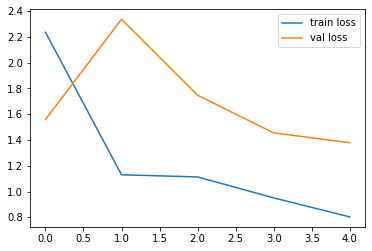

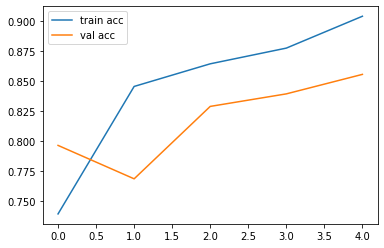

<Figure size 432x288 with 0 Axes>

In [19]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [20]:
test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print('\nTest accuracy:', test_acc)
print('\nTest loss:', test_loss)

870/870 - 14s - loss: 1.6494 - accuracy: 0.8425

Test accuracy: 0.842528760433197

Test loss: 1.6494195461273193


In [21]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score

In [22]:
from sklearn.preprocessing import LabelBinarizer

In [23]:
test_generator.reset()
# get the ground truth of your data. 
y_true = test_generator.classes 

# predict the probability distribution of the data
predictions = model.predict(test_generator, verbose=2)

# get the class with highest probability for each sample
y_pred = np.argmax(predictions, axis=1)

# get the classification report
print(classification_report(y_true, y_pred))

870/870 - 9s
              precision    recall  f1-score   support

           0       0.94      0.85      0.89       155
           1       0.92      0.85      0.88       211
           2       0.82      0.75      0.78       158
           3       0.79      0.89      0.84       148
           4       0.77      0.87      0.82       198

    accuracy                           0.84       870
   macro avg       0.85      0.84      0.84       870
weighted avg       0.85      0.84      0.84       870



In [25]:
print(confusion_matrix(y_true, y_pred))

[[131   6   2   6  10]
 [  6 179   4  15   7]
 [  2   0 119   9  28]
 [  0   4   7 132   5]
 [  1   5  14   6 172]]


In [26]:
 list(train_generator.class_indices.keys())

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

ROC AUC score: 0.9009709061196407


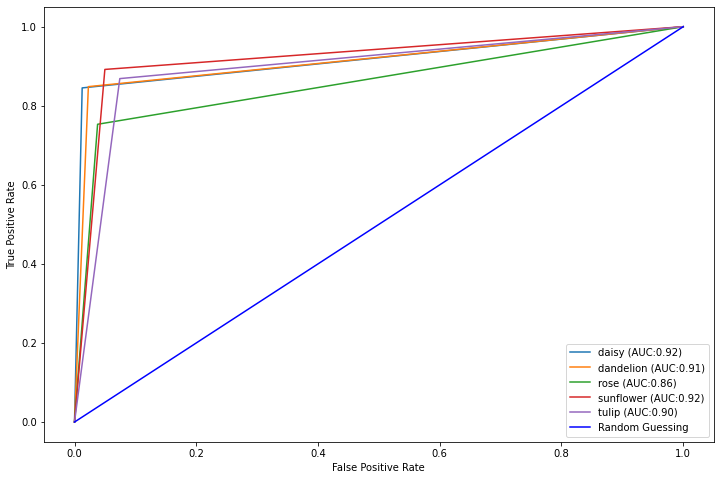

In [48]:
all_labels = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
# set plot figure size
fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

def multiclass_roc_auc_score(y_true, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_true)
    y_true = lb.transform(y_true)
    y_pred = lb.transform(y_pred)

    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(y_true[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_true, y_pred, average=average)


print('ROC AUC score:', multiclass_roc_auc_score(y_true, y_pred))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()

In [49]:
# save it as a h5 file

from tensorflow.keras.models import load_model

model.save('Bunga weight/Xception_bungafinal.h5')

C:\Users\DELL\anaconda3\envs\marzharenv\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


test accuracy : 84.25287356321839


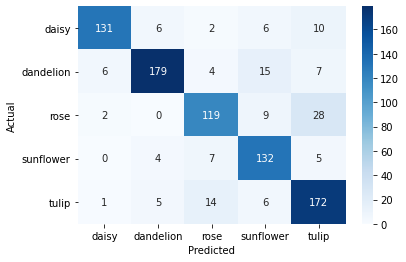

In [50]:
import pandas as pd
import seaborn as sn
import tensorflow as tf

model = tf.keras.models.load_model('Bunga weight/Xception_bungafinal.h5')
filenames = test_generator.filenames
nb_samples = len(test_generator)
y_prob=[]
y_act=[]
test_generator.reset()
for _ in range(nb_samples):
   X_test,Y_test = test_generator.next()
   y_prob.append(model.predict(X_test))
   y_act.append(Y_test)

predicted_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_prob]
actual_class = [list(train_generator.class_indices.keys())[i.argmax()] for i in y_act]

out_df = pd.DataFrame(np.vstack([predicted_class,actual_class]).T,columns=['predicted_class','actual_class'])
confusion_matrix = pd.crosstab(out_df['actual_class'],out_df['predicted_class'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix,cmap='Blues', annot=True,fmt='d')
plt.show
print('test accuracy : {}'.format((np.diagonal(confusion_matrix).sum()/confusion_matrix.sum().sum()*100)))

In [5]:
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [6]:
model=load_model('Bunga weight/Xception_bungafinal.h5')

In [7]:
img=image.load_img('flowers Dataset/test/sunflower/10386503264_e05387e1f7_m.jpg',target_size=(224,224))

In [8]:
x=image.img_to_array(img)
x

array([[[144., 125.,   5.],
        [108., 128.,  41.],
        [123., 133.,  21.],
        ...,
        [121., 133.,  21.],
        [128., 139.,  35.],
        [ 86.,  90.,   3.]],

       [[113., 148.,   2.],
        [ 37.,  93., 242.],
        [ 41.,  90., 227.],
        ...,
        [ 58., 115., 231.],
        [ 68., 120., 242.],
        [ 51.,  62.,  54.]],

       [[149., 143.,  21.],
        [ 44.,  95., 220.],
        [ 55., 105., 190.],
        ...,
        [ 77., 118., 197.],
        [ 71., 130., 248.],
        [ 55.,  66.,  36.]],

       ...,

       [[141., 145.,   6.],
        [  2.,  13.,  15.],
        [ 27.,  41.,  24.],
        ...,
        [110., 151.,  75.],
        [128., 171., 100.],
        [ 53.,  66.,  12.]],

       [[149., 151.,  24.],
        [  0.,  10.,   6.],
        [ 11.,  24.,   0.],
        ...,
        [129., 172., 100.],
        [138., 184., 119.],
        [ 67.,  85.,  35.]],

       [[102.,  97.,   3.],
        [ 33.,  41.,  20.],
        [ 53.,  

In [9]:
x.shape

(224, 224, 3)

In [10]:
x=x/255

In [11]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [12]:
result = model.predict(img_data)
print(result)

[[0.1300654  0.05321424 0.02470369 0.74045455 0.05156206]]


In [13]:
a=np.argmax(model.predict(img_data), axis=1)

In [14]:
if(a==0):
    print("daisy")
elif(a==1):
    print("dandelion")
elif(a==2):
    print("rose")
elif(a==3):
    print("sunflower")
else:
    print("tulip")

sunflower


[[0.1300654  0.05321424 0.02470369 0.74045455 0.05156206]]
Predicted : sunflower


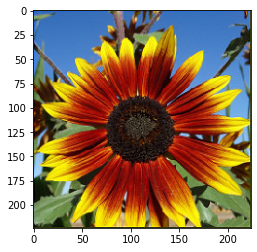

In [17]:
plt.imshow(img)
print(result)
if(a==0):
    print("Predicted : daisy")
elif(a==1):
    print("Predicted : dandelion")
elif(a==2):
    print("Predicted : rose")
elif(a==3):
    print("Predicted : sunflower")
else:
    print("Predicted : tulip")

In [18]:
x

array([[[[-0.99557096, -0.9961553 , -0.9998462 ],
         [-0.9966782 , -0.99606305, -0.99873894],
         [-0.99621683, -0.9959093 , -0.9993541 ],
         ...,
         [-0.99627835, -0.9959093 , -0.9993541 ],
         [-0.99606305, -0.99572474, -0.9989235 ],
         [-0.99735487, -0.99723184, -0.99990773]],

        [[-0.9965244 , -0.99544793, -0.9999385 ],
         [-0.99886197, -0.9971396 , -0.9925567 ],
         [-0.99873894, -0.99723184, -0.9930181 ],
         ...,
         [-0.9982161 , -0.9964629 , -0.99289507],
         [-0.9979085 , -0.9963091 , -0.9925567 ],
         [-0.9984314 , -0.99809307, -0.9983391 ]],

        [[-0.9954171 , -0.9956017 , -0.9993541 ],
         [-0.9986467 , -0.99707806, -0.9932334 ],
         [-0.99830836, -0.9967705 , -0.9941561 ],
         ...,
         [-0.99763167, -0.9963706 , -0.9939408 ],
         [-0.9978162 , -0.99600154, -0.99237216],
         [-0.99830836, -0.99797   , -0.9988927 ]],

        ...,

        [[-0.9956632 , -0.9955402 , -0